In [1]:
# Just import something needed
import numpy as np
import strax
import straxen
import wfsim

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from multihist import Histdd, Hist1d
from scipy import stats
import matplotlib.pyplot as plt

/home/zmind/anaconda3/lib/python3.7/site-packages/datashader/transfer_functions.py:21: FutureWarning: xarray subclass Image should explicitly define __slots__
  class Image(xr.DataArray):


In [2]:
# Strax Settings
n_photon_min = 50
n_photon_max = 350
n_electron_min = 4
n_electron_max = 5

st = strax.Context(
     register=wfsim.RawRecordsFromFax,
#     config=dict((detector="XENONnT"))
    **straxen.contexts.common_opts)

strax.Mailbox.DEFAULT_TIMEOUT=10000

### Generating S2s

In [3]:
st.set_config(dict(fax_file=None))

# Generating S2s
st.set_config(dict(nchunk=1, event_rate = 1, chunk_size = 6))

run_id = '180569_9592'

dtype = wfsim.strax_interface.instruction_dtype

def rand_instructions(c):
    n = c['nevents'] = c['event_rate'] * c['chunk_size'] * c['nchunk']
    c['total_time'] = c['chunk_size'] * c['nchunk']

    instructions = np.zeros(1 * n, dtype=dtype)
    uniform_times = c['total_time'] * (np.arange(n) + 0.5) / n
    instructions['t'] = np.repeat(uniform_times, 1) * int(1e9)
    instructions['event_number'] = np.digitize(instructions['t'], 
         1e9 * np.arange(c['nchunk']) * c['chunk_size']) - 1
    instructions['type'] = np.tile(['s2'], n)
    instructions['recoil'] = ['er' for i in range(n * 1)]

    r = np.sqrt(np.random.uniform(0, 2500, n))
    t = np.random.uniform(-np.pi, np.pi, n)
    instructions['x'] = np.repeat(r * np.cos(t), 1)
    instructions['y'] = np.repeat(r * np.sin(t), 1)
    instructions['z'] = np.repeat(np.random.uniform(-100, 0, n), 1)

    nphotons = np.random.uniform(n_photon_min, n_photon_max, n)
    nelectrons = np.random.uniform(n_electron_min, n_electron_max, n)
    nelectrons = nelectrons/2
    instructions['amp'] = np.vstack([nelectrons]).T.flatten().astype(int)

    return instructions

wfsim.strax_interface.rand_instructions = rand_instructions
wfsim.strax_interface.instruction_dtype = dtype

In [4]:
records_s2_g2100 = st.get_array(run_id,'records')
peaks_s2_g2100 = st.get_array(run_id, ['peaks','peak_classification'])
truth_s2_g2100 = st.get_df(run_id, 'truth')

Removing old incomplete data in ./strax_data/180569_9592-raw_records-s5wloh53a6
Removing old incomplete data in ./strax_data/180569_9592-truth-s5wloh53a6
Removing old incomplete data in ./strax_data/180569_9592-diagnostic_records-2ynoray5hr
Removing old incomplete data in ./strax_data/180569_9592-records-2ynoray5hr
Removing old incomplete data in ./strax_data/180569_9592-aqmon_records-2ynoray5hr
Removing old incomplete data in ./strax_data/180569_9592-pulse_counts-2ynoray5hr
Removing old incomplete data in ./strax_data/180569_9592-veto_regions-2ynoray5hr


Simulating Raw Records: 100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


Source finished!


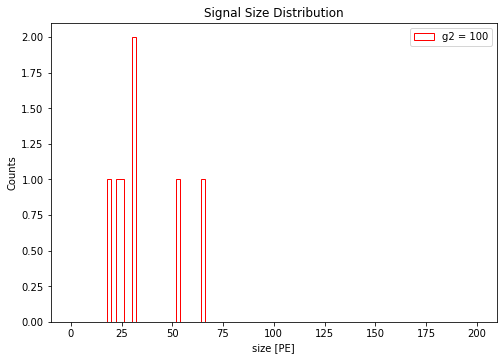

In [5]:
fig=plt.figure(figsize=(8,5.5))
fig.patch.set_color('white')
plt.hist(peaks_s2_g2100['area'],bins=100,range=(0,200),color='r',histtype='step',label='g2 = 100')
plt.legend(loc='best')
plt.xlabel('size [PE]')
plt.ylabel('Counts')
plt.title('Signal Size Distribution')
plt.show()

In [6]:
truth_s2_g2100.head()

,event_number,type,t,x,y,z,amp,recoil,n_photon,n_electron,t_first_photon,t_last_photon,t_mean_photon,t_sigma_photon,t_first_electron,t_last_electron,t_mean_electron,t_sigma_electron
0,0,s2,500000000,8.165978,-29.695333,-56.776592,2,er,57.0,2.0,5.004270e+08,5.004281e+08,5.004275e+08,364.634555,5.004269e+08,5.004276e+08,5.004272e+08,342.115496
1,0,s2,1500000000,-3.931398,-37.735703,-18.339689,2,er,46.0,2.0,1.500139e+09,1.500140e+09,1.500139e+09,154.556402,1.500139e+09,1.500139e+09,1.500139e+09,81.117765
2,0,s2,2500000000,14.812944,-5.681142,-29.128050,2,er,25.0,1.0,2.500219e+09,2.500220e+09,2.500219e+09,157.529728,2.500219e+09,2.500219e+09,2.500219e+09,0.000000
3,0,s2,3500000000,27.641562,-3.539320,-42.889709,2,er,17.0,1.0,3.500323e+09,3.500324e+09,3.500324e+09,128.811409,3.500323e+09,3.500323e+09,3.500323e+09,0.000000
4,0,s2,4500000000,0.403393,-22.432146,-95.246033,2,er,24.0,1.0,4.500714e+09,4.500714e+09,4.500714e+09,147.422509,4.500714e+09,4.500714e+09,4.500714e+09,0.000000
